In [28]:
import sys
sys.path.append('../')

import torch
from torchvision import transforms, models
from torchvision.io import read_image
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from models import get_encoder_architecture_usage
import argparse
from optimize_filter.tiny_network import U_Net_tiny
from util import clamp_batch_images

torch.cuda.set_device(1)

args=argparse.Namespace(
    pretrained_encoder='../output/cifar10/clean_encoder/model_1000.pth',
    encoder_usage_info='cifar10',
    filter='../output/cifar10/svhn_backdoored_encoder/2023-12-26-13:50:32/unet_filter_200_trained.pt',
)

test_transform_cifar10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ])

# Define the transform
finetune_transform_cifar10 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=1),
    transforms.RandomGrayscale(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

# Load the image
img_path = '../data/cifar10/test/image_9922_label_[5].jpeg'  # Replace with the path to the image file
original_image = Image.open(img_path).convert('RGB')

# Let's assume we want to generate 100 transformed versions of the image
num_samples = 1000
all_transformed_images = []

In [29]:
import torch.nn.functional as F
import os,random,copy
import kornia.augmentation as A

class ProbTransform(torch.nn.Module):
    def __init__(self, f, p=1):
        super(ProbTransform, self).__init__()
        self.f = f
        self.p = p

    def forward(self, x):  # , **kwargs):
        if random.random() < self.p:
            return self.f(x)
        else:
            return x
class PostTensorTransform(torch.nn.Module):
    def __init__(self):
        super(PostTensorTransform, self).__init__()
        self.random_crop = ProbTransform(
            A.RandomCrop((32, 32), padding=5), p=0.8
        )
        self.random_rotation = ProbTransform(A.RandomRotation(10), p=0.5)


    def forward(self, x):
        for module in self.children():
            x = module(x)
        return x


def wanet(clean_img):
    input_height=32
    grid_rescale=1
    s=0.5
    k=4
    num_bd = 1
    num_cross = num_bd
    ins = torch.rand(1, 2, k, k) * 2 - 1
    ins = ins / torch.mean(torch.abs(ins))
    noise_grid = (
        F.upsample(ins, size=input_height, mode="bicubic", align_corners=True)
        .permute(0, 2, 3, 1)
    )
    array1d = torch.linspace(-1, 1, steps=input_height)
    x, y = torch.meshgrid(array1d, array1d)
    identity_grid = torch.stack((y, x), 2)[None, ...]

    grid_temps = (identity_grid + s * noise_grid / input_height) * grid_rescale
    grid_temps = torch.clamp(grid_temps, -1, 1)
    transforms = PostTensorTransform()

    ins = torch.rand(num_cross, input_height, input_height, 2) * 2 - 1
    grid_temps2 = grid_temps.repeat(num_cross, 1, 1, 1) + ins / input_height
    grid_temps2 = torch.clamp(grid_temps2, -1, 1)

    inputs_bd = F.grid_sample(clean_img.unsqueeze(0), grid_temps.repeat(num_bd, 1, 1, 1), align_corners=True)

    # inputs_cross = F.grid_sample(img_backdoor[num_bd : (num_bd + num_cross)], grid_temps2, align_corners=True)

    # total_inputs = torch.cat([inputs_bd, inputs_cross], dim=0)
    backdoored_img = transforms(inputs_bd)
    return backdoored_img

def patch_backdoor(clean_img):
    trigger_input_array = np.load('../trigger/trigger_pt_white_21_10_ap_replace.npz')
    trigger_patch_list = trigger_input_array['t']
    trigger_mask_list = trigger_input_array['tm']

    backdoored_image = copy.deepcopy(clean_img)
    backdoored_image = np.array(backdoored_image)
    backdoored_image[:,:,:] = clean_img * trigger_mask_list[0] + trigger_patch_list[0][:]
    img_backdoor =test_transform_cifar10(Image.fromarray(backdoored_image))
    return img_backdoor

# backdoor_img = patch_backdoor(original_image)
# import matplotlib.pyplot as plt

# # Assume `array` is your array
# plt.imshow(backdoor_img)

# # Show the image
# plt.show()

In [30]:
# Load a pretrained encoder
# Here we will use resnet18 as an example of an encoder, but this could be any model

checkpoint = torch.load(args.pretrained_encoder)
encoder = get_encoder_architecture_usage(args).cuda()
encoder.load_state_dict(checkpoint['state_dict'])

net = U_Net_tiny(img_ch=3,output_ch=3)
state_dict = torch.load(args.filter, map_location=torch.device('cuda:0'))
net.load_state_dict(state_dict['model_state_dict'])
net=net.cuda().eval()

# Ensure the encoder is in evaluation mode
encoder.eval()

# Apply the transformation multiple times to the image
for _ in range(num_samples):
    transformed_image = finetune_transform_cifar10(original_image)
    all_transformed_images.append(transformed_image)



transformed_image_clean = test_transform_cifar10(original_image)
all_transformed_images.append(transformed_image_clean) # clean image

img_backdoor_filter=net(transformed_image_clean.unsqueeze(0).cuda())
img_backdoor_filter=clamp_batch_images(img_backdoor_filter,args).squeeze(0).detach().cpu() # filter image

all_transformed_images.append(img_backdoor_filter)


img_wanet = wanet(test_transform_cifar10(original_image)).squeeze(0)
all_transformed_images.append(img_wanet)


img_patch = patch_backdoor(original_image)
all_transformed_images.append(img_patch)

# Convert list of tensors to a single tensor
all_transformed_images_tensor = torch.stack(all_transformed_images).cuda()


# Disable gradient computation since we are only doing inference
with torch.no_grad():
    # Pass the transformed images through the encoder
    encoded_features = encoder(all_transformed_images_tensor)

features_np = encoded_features[0].detach().cpu().numpy()
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
features_tsne = tsne.fit_transform(features_np)


/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


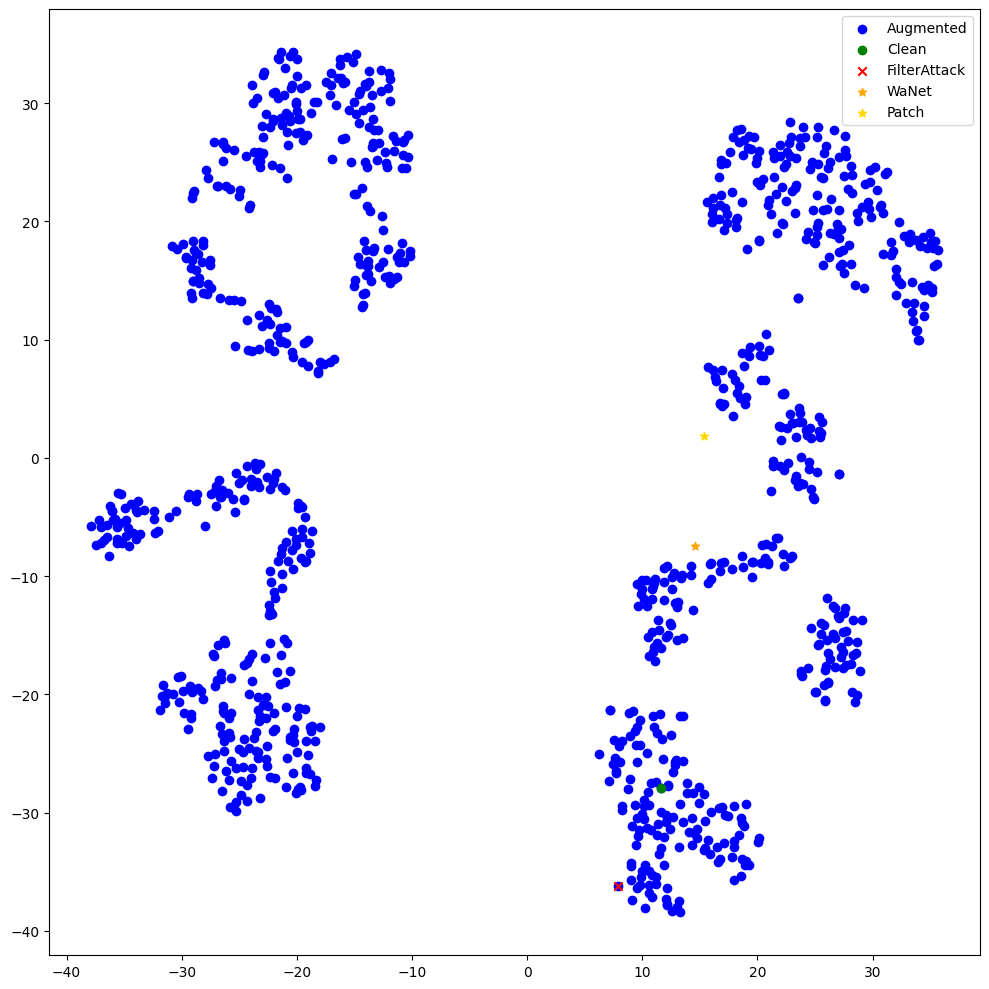

In [31]:
transformed_aug = features_tsne[:-2]
transformed_clean = features_tsne[-4:-3]
transformed_filter = features_tsne[-3:-2]
transformed_wanet = features_tsne[-2:-1]
transformed_patch = features_tsne[-1:]
# transformed_aug = np.array([i for i in transformed_aug if i[1]<20])
# Plotting the t-SNE reduced features
plt.figure(figsize=(10, 10))
plt.scatter(transformed_aug[:, 0], transformed_aug[:, 1], c='blue', label='Augmented')
plt.scatter(transformed_clean[:, 0], transformed_clean[:, 1], c='green', label='Clean')
plt.scatter(transformed_filter[:, 0], transformed_filter[:, 1], c='red', label='FilterAttack', marker='x')
plt.scatter(transformed_wanet[:, 0], transformed_wanet[:, 1], c='orange', label='WaNet', marker='*')
plt.scatter(transformed_patch[:, 0], transformed_patch[:, 1], c='gold', label='Patch', marker='*')

# plt.title('t-SNE visualization of image features')
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('TSNE/insight_origin.png')
plt.show()


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 768 samples in 0.001s...
[t-SNE] Computed neighbors for 768 samples in 0.052s...
[t-SNE] Computed conditional probabilities for sample 768 / 768
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.540138
[t-SNE] KL divergence after 300 iterations: 0.729987


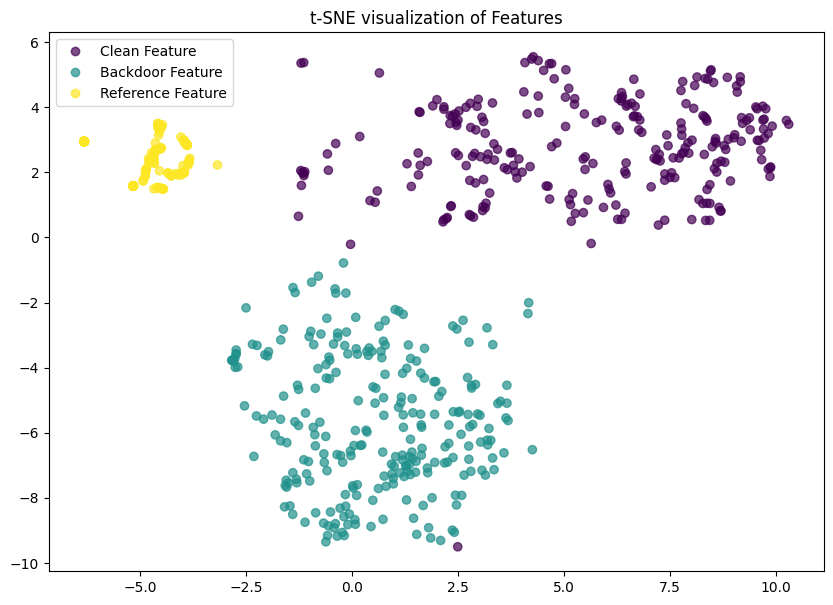

In [37]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load your checkpoint file
# Assuming the checkpoint file has already been loaded as per your command
checkpoint = torch.load('../output/stl10/cifar10_backdoored_encoder/2024-02-01-22:03:17/features_5.pth')

# Extract features from the checkpoint
clean_feature_raw = checkpoint['clean_feature_raw'].detach().cpu()
feature_backdoor = checkpoint['feature_backdoor'].detach().cpu()
feature_reference = checkpoint['feature_reference'].detach().cpu()

# Prepare the data for t-SNE
# Note: Depending on the size of your data, you might want to sample or reduce it for quicker execution
data = np.concatenate((clean_feature_raw, feature_backdoor, feature_reference), axis=0)

# Labels for visualization
labels = np.concatenate((np.zeros(clean_feature_raw.shape[0]), # 0 for clean_feature_raw
                         np.ones(feature_backdoor.shape[0]), # 1 for feature_backdoor
                         2*np.ones(feature_reference.shape[0]))) # 2 for feature_reference

# Run t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data)

# Visualization
plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=labels, cmap='viridis', alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=['Clean Feature', 'Backdoor Feature', 'Reference Feature'])
plt.title('t-SNE visualization of Features')
plt.show()
